## 📦 [데이터셋] 전자상거래 배송 데이터 (Customer Analytics)

본 데이터셋은 국제 전자상거래 업체의 고객 데이터로, **제품 배송의 정시 도착 여부**를 분석하고 예측하기 위한 목적으로 구성되었습니다.

### 1. 타겟 변수 (Target Variable)
* **Reached.on.Time_Y.N**: 제품의 정시 도착 여부
    * **1**: 지연 도착 (Delayed)
    * **0**: 정시 도착 (On Time)

---

### 2. 데이터 컬럼 상세 설명 (Features)

| 컬럼명 | 설명 | 데이터 타입 | 비고 (Perspective) |
| :--- | :--- | :--- | :--- |
| **ID** | 고객 고유 식별 번호 | Integer | 예측 모델 구축 시 제거 대상 |
| **Warehouse_block** | 창고 구역 (A, B, C, D, E) | Object | 구역별 물류 부하 및 병목 현상 확인 |
| **Mode_of_Shipment** | 배송 수단 (Ship, Flight, Road) | Object | 수단별 지연율(지연 비중) 분석의 핵심 |
| **Customer_care_calls** | 고객 센터 문의 전화 횟수 | Integer | 배송 지연에 따른 고객 불만 척도 |
| **Customer_rating** | 고객 만족도 점수 (1~5) | Integer | 지연 여부와 만족도의 상관관계 분석 |
| **Cost_of_the_Product** | 제품 가격 (USD) | Integer | 고가 제품의 우선 배송 여부 확인 |
| **Prior_purchases** | 이전 구매 횟수 | Integer | 충성 고객 대상 배송 서비스 수준 확인 |
| **Product_importance** | 제품 중요도 (low, med, high) | Object | 중요도에 따른 배송 지연 차이 존재 여부 |
| **Gender** | 고객 성별 (F, M) | Object | 성별에 따른 구매 패턴 차이 확인 |
| **Discount_offered** | 할인 금액 | Integer | **핵심 가설:** 할인 폭이 크면 주문 폭주로 지연 가능성 높음 |
| **Weight_in_gms** | 제품 무게 (g) | Integer | 무게에 따른 배송 수단 제한 및 지연 영향 |

---

### 3. 분석 전략 (Initial Strategy)

1. **데이터 정제:** ID 컬럼 삭제 및 범주형 변수(Warehouse, Mode 등) 수치화.
2. **핵심 가설 검증:** - 할인(`Discount_offered`)과 배송 지연(`1`)의 상관관계 분석.
   - 제품 무게(`Weight_in_gms`)가 배송 수단별 지연에 미치는 영향 분석.
3. **성능 지표:** 모델의 예측 성능은 **ROC-AUC** 점수를 기준으로 평가함.

### 0. 데이터 불러오기, 기본 코드

In [1]:
#!/bin/bash
# !kaggle datasets download prachi13/customer-analytics

In [2]:
#import zipfile
import os

HOME = os.getcwd()
HOME

# zip_file_path = 'customer-analytics.zip'

# extract_to_path = 'data'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

'c:\\Users\\min2m\\github\\project\\E-commerce\\KHM'

In [3]:
import platform
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분할 및 하이퍼파라미터 튜닝
from sklearn.model_selection import train_test_split, GridSearchCV

# 데이터 전처리 및 성능 평가 지표
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    classification_report
)
from sklearn.metrics import precision_score, recall_score, f1_score

# 머신러닝 알고리즘 (부스팅, 앙상블 등)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


# 1. 환경 설정 및 경고 무시
# ---------------------------------------------------------
warnings.filterwarnings('ignore') # 모든 FutureWarning 및 경고 무시

# 2. 한글 폰트 설정 (OS별 대응)
# ---------------------------------------------------------
if platform.system() == 'Darwin':     # 맥(macOS)
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

In [4]:
Train = pd.read_csv('data/train_df.csv')
test = pd.read_csv('data/test_df.csv')

Train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,5246,F,Ship,4,4,263,3,medium,M,10,4680,0
1,4842,F,Ship,5,1,156,6,medium,F,4,4821,0
2,3491,C,Ship,3,1,256,4,medium,F,3,4398,1
3,284,F,Flight,5,4,165,3,low,F,20,1150,1
4,8149,D,Ship,3,2,176,2,medium,F,1,5292,0


### 1. 검증용 데이터 분리

In [ ]:
# 1. stratify 옵션을 써서 정답(Reached.on.Time_Y.N) 비율을 유지하며 8:2로 나눕니다.
# 이 함수는 내부적으로 데이터를 랜덤하게 섞어주기 때문에 sample을 따로 안 써도 됩니다.
part1, part2 = train_test_split(Train, 
                                test_size=0.2, 
                                random_state=42, 
                                stratify=Train['Reached.on.Time_Y.N'])

# 2. 각각 파일로 저장
part1.to_csv('data/train_df.csv', index=False)
part2.to_csv('data/test_df.csv', index=False)

print("데이터 분할 및 저장 완료!")
print(f"학습용: {part1.shape}, 테스트용: {part2.shape}")

데이터 분할 및 저장 완료!
학습용: (1180, 12), 테스트용: (295, 12)


In [6]:
Train = pd.read_csv('data/train_df.csv')
test = pd.read_csv('data/test_df.csv')

Train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,9043,D,Flight,3,5,238,2,low,F,8,5769,0
1,5686,B,Ship,4,3,235,6,medium,M,2,4689,0
2,6296,F,Road,4,3,240,5,medium,F,5,1301,0
3,10735,D,Ship,5,5,275,5,low,M,4,1646,0
4,791,C,Ship,4,3,200,2,medium,M,65,3485,1


In [7]:
print(Train.columns)

Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')


### 2. 데이터 확인

In [8]:
# [1-1] 전체적인 구조와 결측치 확인
print("--- 🩺 데이터 기본 정보 ---")
print(Train.info())

# [1-2] 수치형 데이터의 통계적 분포 (평균, 최소/최대 등)
print("\n--- 📊 수치형 데이터 요약 통계 ---")
display(Train.describe())

--- 🩺 데이터 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   1180 non-null   int64 
 1   Warehouse_block      1180 non-null   object
 2   Mode_of_Shipment     1180 non-null   object
 3   Customer_care_calls  1180 non-null   int64 
 4   Customer_rating      1180 non-null   int64 
 5   Cost_of_the_Product  1180 non-null   int64 
 6   Prior_purchases      1180 non-null   int64 
 7   Product_importance   1180 non-null   object
 8   Gender               1180 non-null   object
 9   Discount_offered     1180 non-null   int64 
 10  Weight_in_gms        1180 non-null   int64 
 11  Reached.on.Time_Y.N  1180 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 110.8+ KB
None

--- 📊 수치형 데이터 요약 통계 ---


,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,5478.000847,4.050000,2.978814,209.549153,3.551695,13.838136,3637.872881,0.597458
std,3156.893289,1.141421,1.379134,49.004856,1.543227,16.612944,1622.363696,0.490618
min,5.000000,2.000000,1.000000,97.000000,2.000000,1.000000,1008.000000,0.000000
25%,2648.750000,3.000000,2.000000,167.750000,3.000000,4.000000,1855.250000,0.000000
50%,5526.000000,4.000000,3.000000,211.500000,3.000000,7.000000,4149.500000,1.000000
75%,8123.250000,5.000000,4.000000,251.000000,4.000000,10.000000,5033.250000,1.000000
max,10994.000000,7.000000,5.000000,310.000000,10.000000,65.000000,5996.000000,1.000000


In [9]:
# 범주형 변수 분석 : 글자로 된 변수들은 '개수'와 '지연율'을 보는 게 핵심
# 반복되는 분석은 반복문(for)으로 깔끔하게!
cat_features = ['Warehouse_block', 'Mode_of_Shipment', 'Gender', 'Product_importance']

for col in cat_features:
    print(f"\n🔍 [{col}] 컬럼 상세 분석")
    # 1. 개수 확인
    print(Train[col].value_counts())
    # 2. 지연율 확인 (상관관계 파악)
    display(Train.groupby(col)['Reached.on.Time_Y.N'].mean().sort_values(ascending=False))


🔍 [Warehouse_block] 컬럼 상세 분석
Warehouse_block
F    392
D    205
B    205
A    197
C    181
Name: count, dtype: int64


Warehouse_block
A    0.629442
D    0.604878
F    0.604592
C    0.602210
B    0.541463
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Mode_of_Shipment] 컬럼 상세 분석
Mode_of_Shipment
Ship      804
Road      192
Flight    184
Name: count, dtype: int64


Mode_of_Shipment
Ship      0.615672
Flight    0.570652
Road      0.546875
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Gender] 컬럼 상세 분석
Gender
F    615
M    565
Name: count, dtype: int64


Gender
M    0.610619
F    0.585366
Name: Reached.on.Time_Y.N, dtype: float64


🔍 [Product_importance] 컬럼 상세 분석
Product_importance
low       590
medium    485
high      105
Name: count, dtype: int64


Product_importance
low       0.613559
medium    0.581443
high      0.580952
Name: Reached.on.Time_Y.N, dtype: float64

> Product_importance
* XGBoost 모델이 이 변수를 중요하게 쓰겠지만, high 데이터의 개수가 768개로 적은 편
* 768개가 특정 창고(Warehouse_block)에 몰려있는지 확인 후 -> 파생변수 만들지 여부 정하기

> Gender --> drop (+ID)

> Mode_of_Shipment
* 배(Ship), 비행기(Flight), 도로(Road)의 지연율이 거의 비슷(0.58~0.60).
* **'배송 수단 + 무게?'** 등을 조합한 파생변수 만들지 여부 정하기

> Warehouse_block
* F구역이 데이터는 압도적으로 많지만(2,910개), 지연율은 모든 구역이 58~60%로 일정
* 특정 구역이나 수단의 고질적 문제라기보다, 전체적인 물류 프로세스의 공통적인 지연 요소가 있을 것으로 판단됨.

In [10]:
# "중요도(high)는 특정 창고에 몰려있을까?"
# 창고별 제품 중요도 분포
importance_warehouse = pd.crosstab(Train['Warehouse_block'], Train['Product_importance'])
print("--- 🏢 창고별 중요도 제품 건수 ---")
print(importance_warehouse)

# 지연율까지 같이 보고 싶다면?
importance_delay = Train.pivot_table(index='Warehouse_block', 
                                     columns='Product_importance', 
                                     values='Reached.on.Time_Y.N', 
                                     aggfunc='mean')
print("\n--- 🚨 창고x중요도별 지연율 (%) ---")
display(importance_delay * 100)

--- 🏢 창고별 중요도 제품 건수 ---
Product_importance  high  low  medium
Warehouse_block                      
A                     15  104      78
B                     12   96      97
C                     25   88      68
D                     16  104      85
F                     37  198     157

--- 🚨 창고x중요도별 지연율 (%) ---


Product_importance,high,low,medium
Warehouse_block,,,
A,60.000000,61.538462,65.384615
B,58.333333,57.291667,50.515464
C,56.000000,64.772727,55.882353
D,62.500000,60.576923,60.000000
F,56.756757,62.121212,59.235669


> 창고 A는 중요도 high 제품 지연율이 70.08% / 유독 중요한 물건을 다룰 때 병목현상이 심하게 일어남 
* 근데 데이터 개수 127개 >> 파생변수는 만들지 않는 게 더 나은 선택 (일반화 하기에 너무 작은 표본)
* XGBoost 돌리면 알아서 처리

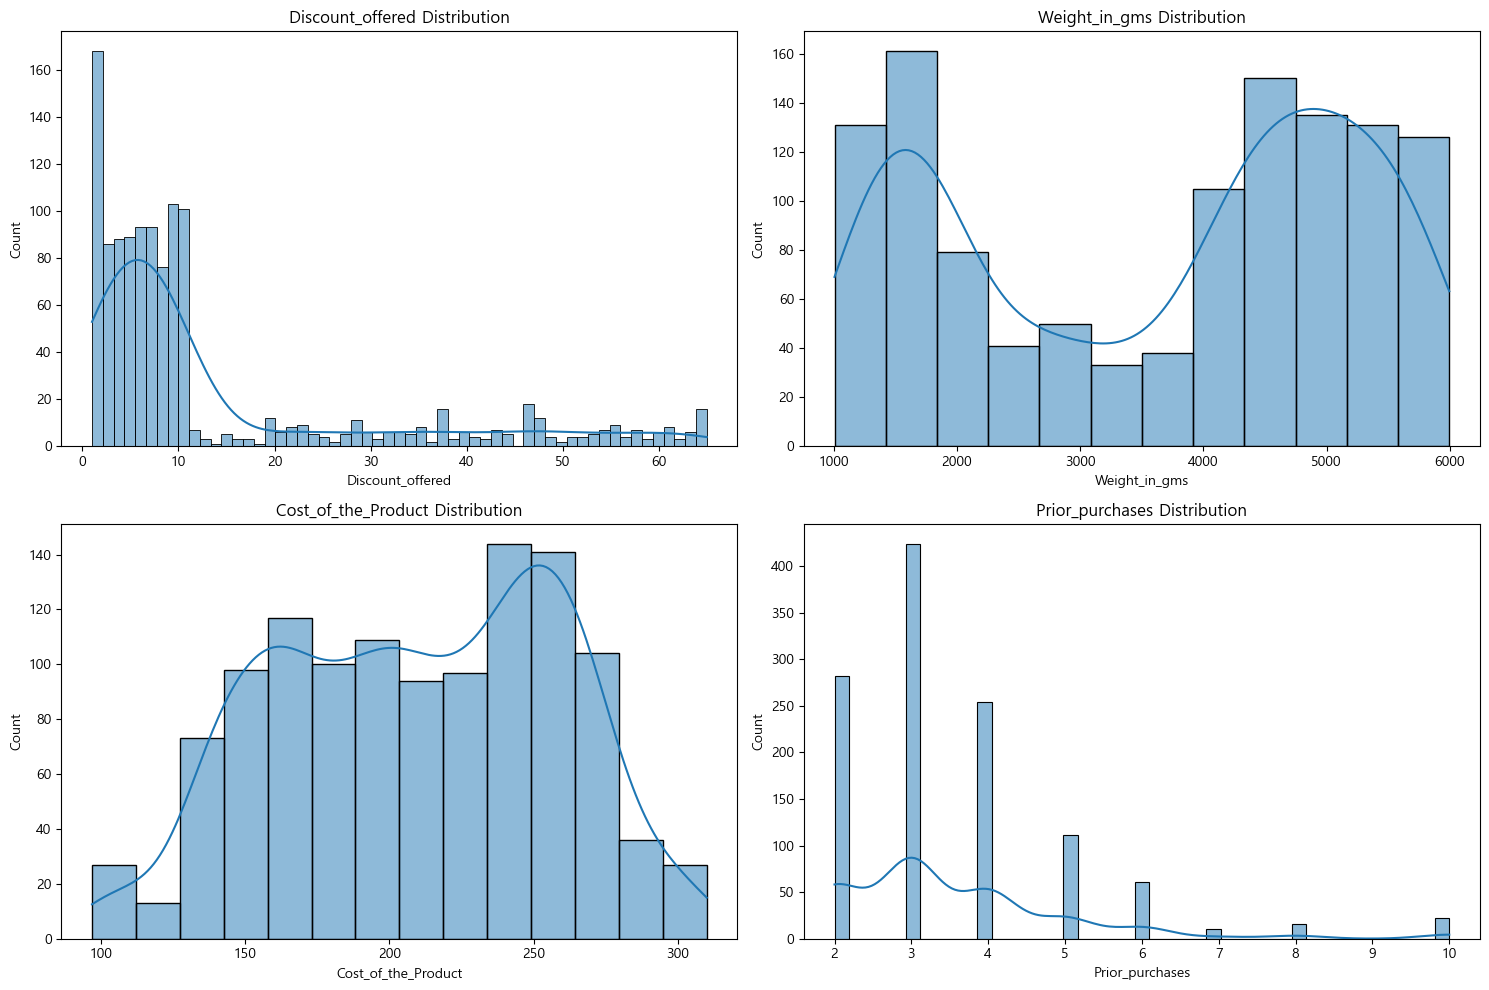

In [11]:
# 숫자형 변수 분석 : 분포 + 이상치 확인
num_features = ['Discount_offered', 'Weight_in_gms', 'Cost_of_the_Product', 'Prior_purchases']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(Train[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

> Discount_offered (할인) - ⚠️ 10.5 (지니계수가 가장 적은 게 10.5라고 계산함)
* $10.5$달러 이상의 고액 할인은 주문 폭주를 일으켜 과부하되는 듯

> Weight_in_gms (제품 무게) - 🚨 위험 구간 2~4kg
* 특정 무게 구간(2,000g~4,000g)에서 지연 데이터가 비정상적으로 많이 관찰
* 어중간한 2~4kg 무게가 포장이나 적재 시 가장 많이 지연되는 '데드 존(Dead Zone)'

*** 가설1 : 할인 품목이 2~4kg가 많지 않을까 하는 생각<br>
*** 가설2 : 가벼운것/무거운것보다 중간이 많으니까 어디 밀려났다가 한꺼번에 처리하지 않을까 하는 추측

> Cost_of_the_Product (제품 가격)
* 어느 한 곳에 쏠리지 않고 골고루 분포됨. 무게랑 같이 엮어서 **'무게 대비 가격(Value Density)'** 파생 변수를 만들기

> Prior_purchases(이전 구매 횟수)
* 3회 구매자가 가장 많고, 6회 이상부터는 데이터가 확 줄어듦
* 재구매 6회 이상 단골고객 패턴은 비슷하니, 모델이 헷갈리지 않게 하나로 묶어주기

> Weight_in_gms 가설 확인
* 가설1 : 할인 품목이 2~4kg가 많아서 지연<br>
* 가설2 : 가벼운것/무거운것보다 중간 무게가 많아서 물량이 많은만큼 지연

--- 💸 무게 구간별 할인액 통계 ---
                        mean  median  count
Weight_Group                               
1. Small (<2kg)    17.348703     8.0    347
2. Medium (2-4kg)  34.957672    35.0    189
3. Large (>4kg)     5.748447     6.0    644

--- 📦 무게 구간별 물동량(건수) 비교 ---
Weight_Group
3. Large (>4kg)      54.576271
1. Small (<2kg)      29.406780
2. Medium (2-4kg)    16.016949
Name: proportion, dtype: float64


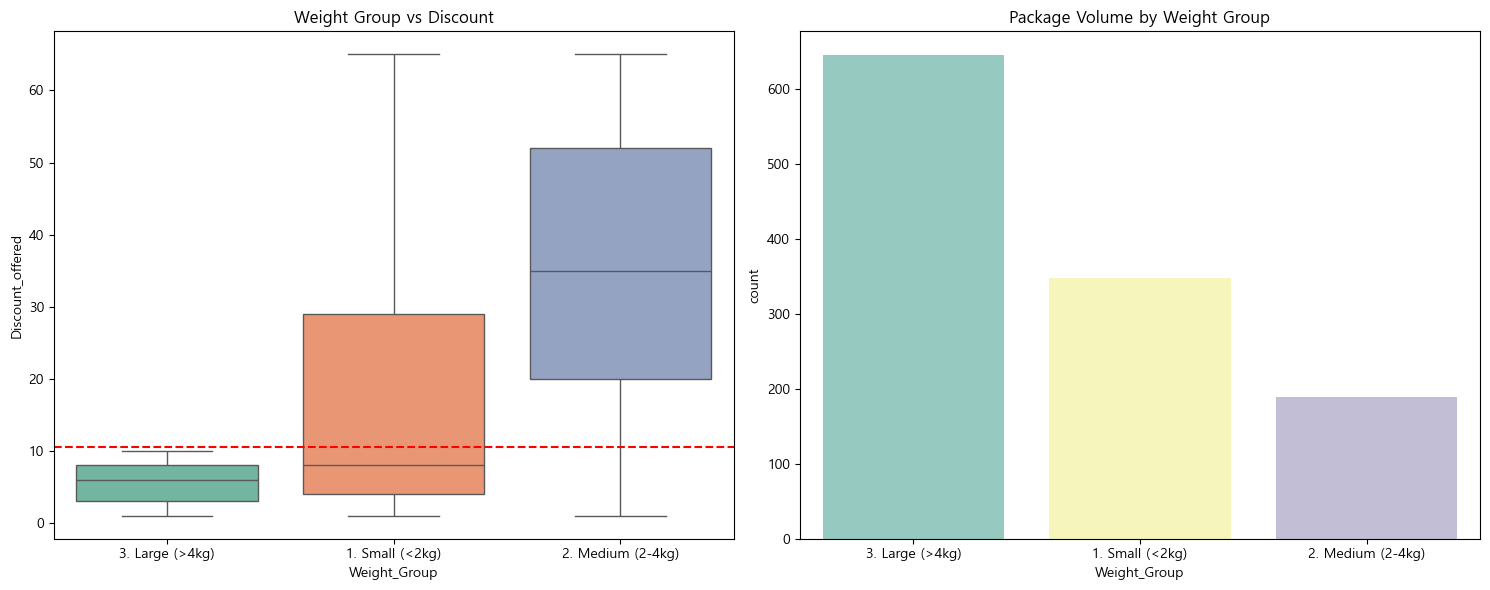

In [12]:
# [1] 무게 구간 나누기 (2~4kg를 집중적으로 보기 위함)
def categorize_weight(w):
    if w < 2000: return '1. Small (<2kg)'
    elif 2000 <= w <= 4000: return '2. Medium (2-4kg)'
    else: return '3. Large (>4kg)'

# 전처리 중인 데이터프레임(Train)에 적용
Train['Weight_Group'] = Train['Weight_in_gms'].apply(categorize_weight)

# [2] 가설 1 확인: "2~4kg에 할인 품목이 몰려 있는가?"
# 무게 구간별 할인액(Discount_offered)의 평균과 중앙값 확인
discount_analysis = Train.groupby('Weight_Group')['Discount_offered'].agg(['mean', 'median', 'count'])
print("--- 💸 무게 구간별 할인액 통계 ---")
print(discount_analysis)

# [3] 가설 2 확인: "2~4kg 물량이 압도적으로 많아서 밀리는가?"
# 위에서 구한 'count' 컬럼이 바로 물동량(Volume)
print("\n--- 📦 무게 구간별 물동량(건수) 비교 ---")
print(Train['Weight_Group'].value_counts(normalize=True) * 100) # 퍼센트로 보기

# [4] 시각화로 한눈에 확인 (Boxplot + Countplot)
plt.figure(figsize=(15, 6))

# 왼쪽: 할인율 분포 (가설 1 검증)
plt.subplot(1, 2, 1)
sns.boxplot(data=Train, x='Weight_Group', y='Discount_offered', palette='Set2')
plt.axhline(10.5, color='red', linestyle='--', label='High Discount Line')
plt.title('Weight Group vs Discount')

# 오른쪽: 물동량 확인 (가설 2 검증)
plt.subplot(1, 2, 2)
sns.countplot(data=Train, x='Weight_Group', palette='Set3')
plt.title('Package Volume by Weight Group')

plt.tight_layout()
plt.show()

> 결과

**가설1** ⭕
* 2~4kg 그룹의 평균할인액 32.69 중앙값 34.0
* 다른 그룹(Small: 16.7달러, Large: 5.5달러)과 비교하면 압도적으로 높은 할인이 이 구간에 쏠림
* 기업이 가장 공격적으로 프로모션을 진행하는 '전략 상품군'이 바로 이 2~4kg 무게대에 집중되어 있다

**가설2** ❌
* 물동량 1위는 Large (>4kg) 그룹으로,53.9%
* Medium (2-4kg) 16.5% - 물량이 가장 적음
* 물량이 많아서 밀리는 게 아니라 '할인 폭이 너무 커서' 주문이 한꺼번에 몰리거나, 특별 관리가 필요해서 지연되는 '프로모션의 함정' 구간임

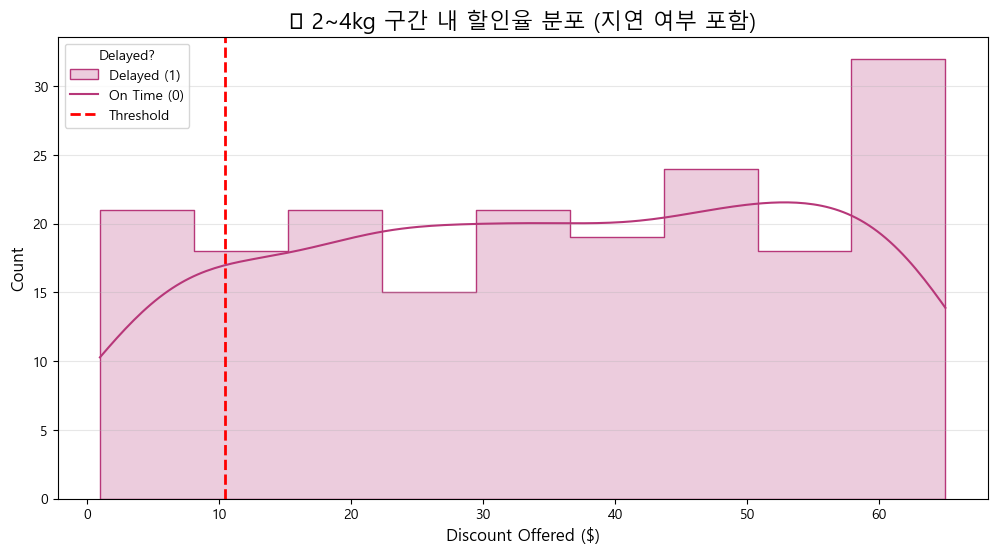

--- 📊 2~4kg 구간 심층 통계 ---
1. 전체 건수: 189건
2. 10.5$ 초과 고액 할인 건수: 160건
3. 고액 할인 비중: 🔥 84.7% 🔥


In [13]:
# [Section 2-6] 2~4kg 구간(Danger Zone) 내부의 할인율 분포 및 비중 확인

# 1. 2~4kg 데이터만 필터링
danger_weight_df = Train[(Train['Weight_in_gms'] >= 2000) & (Train['Weight_in_gms'] <= 4000)]

# 2. 시각화 (지연 여부로 색깔 구분!)
plt.figure(figsize=(12, 6))
sns.histplot(data=danger_weight_df, x='Discount_offered', hue='Reached.on.Time_Y.N', 
             kde=True, palette='magma', element="step")

# 3. 10.5 선 긋기
plt.axvline(10.5, color='red', linestyle='--', linewidth=2, label='Magic Line: 10.5$')

plt.title('📦 2~4kg 구간 내 할인율 분포 (지연 여부 포함)', fontsize=16)
plt.xlabel('Discount Offered ($)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Delayed?', labels=['Delayed (1)', 'On Time (0)', 'Threshold'])
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4. 수치 확인
total_cnt = len(danger_weight_df)
high_discount_cnt = len(danger_weight_df[danger_weight_df['Discount_offered'] > 10.5])
percentage = (high_discount_cnt / total_cnt) * 100 if total_cnt > 0 else 0

print(f"--- 📊 2~4kg 구간 심층 통계 ---")
print(f"1. 전체 건수: {total_cnt}건")
print(f"2. 10.5$ 초과 고액 할인 건수: {high_discount_cnt}건")
print(f"3. 고액 할인 비중: 🔥 {percentage:.1f}% 🔥") # 소수점 첫째자리까지 표시

> 무게(Weight)와 할인(Discount)의 관계

제품 무게 2,000g~4,000g 구간은 물동량 비중은 **16.5%**로 가장 낮지만, 평균 할인액은 32.69달러로 타 구간 대비 압도적으로 높음.

결론: 해당 구간의 높은 지연율은 '물량 과부하' 때문이 아니라, 고액 할인이 집중된 프로모션 상품들의 주문 처리 과정에서 발생하는 병목 현상이 주원인으로 분석됨.

전략: 따라서 Is_Danger_Weight 파생 변수는 단순히 무게를 보는 것이 아니라, **'고할인 전략 상품군'을 식별하는 대리 변수(Proxy Variable)**로서 강력한 예측력을 가지게 됨.

### 🛠️ 3. Feature Engineering (변수 생성 및 데이터 정제)

In [14]:
# [1] 팀 규칙: 즉시 8:2 분할 (분석의 신뢰도를 위해 전처리 전 수행)
train_data, val_data = train_test_split(
    Train, test_size=0.2, random_state=42, stratify=Train['Reached.on.Time_Y.N']
)

# [2] 정예 멤버 11인을 위한 최종 전처리 함수 정의
def get_final_master_df(df):
    temp = df.copy()
    
    # 1. 핵심 파생 변수 생성 (할인, 무게, 가치밀도)
    temp['Is_High_Discount'] = (temp['Discount_offered'] > 10.5).astype(int)
    temp['Is_Danger_Weight'] = temp['Weight_in_gms'].between(2000, 4000).astype(int)
    temp['Value_Density'] = temp['Cost_of_the_Product'] / temp['Weight_in_gms']
    
    # 2. 범주형 데이터 수치화 및 클리닝
    temp['Prior_purchases'] = temp['Prior_purchases'].apply(lambda x: 6 if x >= 6 else x)
    mapping = {'low': 1, 'medium': 2, 'high': 3}
    if temp['Product_importance'].dtype == 'object':
        temp['Product_importance'] = temp['Product_importance'].str.lower().map(mapping)
    
    # 3. 기타 범주형 인코딩
    cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_rating']
    for col in cat_cols:
        if col in temp.columns:
            temp[col] = pd.Categorical(temp[col]).codes
            
    # 4. 정예 11개 변수 + 타겟 변수 선택
    final_features = [
        'Discount_offered', 'Is_Danger_Weight', 'Warehouse_block', 
        'Cost_of_the_Product', 'Customer_care_calls', 'Weight_in_gms', 
        'Value_Density', 'Mode_of_Shipment', 'Customer_rating', 
        'Prior_purchases', 'Product_importance', 'Reached.on.Time_Y.N'
    ]
    return temp[[f for f in final_features if f in temp.columns]]

# [3] 전처리 실행 및 데이터 준비
Train_ready = get_final_master_df(train_data)
Val_ready = get_final_master_df(val_data)

X_train = Train_ready.drop(columns=['Reached.on.Time_Y.N'])
y_train = Train_ready['Reached.on.Time_Y.N']
X_val = Val_ready.drop(columns=['Reached.on.Time_Y.N'])
y_val = Val_ready['Reached.on.Time_Y.N']

print(f"✅ 전처리 완료! 학습용: {X_train.shape}, 검증용: {X_val.shape}")

✅ 전처리 완료! 학습용: (944, 11), 검증용: (236, 11)


### 🤖 4. 모델 학습 및 검증 (Model Training)

In [40]:
# [1] 그리드 서치로 검증된 최적의 모델
final_model = XGBClassifier(
    n_estimators=1000, 
    learning_rate=0.005,    # 최적값 반영
    max_depth=2,            # 최적값 반영
    subsample=0.8,          # 최적값 반영
    colsample_bytree=0.8, 
    random_state=42,
    eval_metric='logloss', 
    early_stopping_rounds=100 # 보폭이 작으니 조금 더 끈기있게 지켜봄
)

# [2] 최종 학습 시작
final_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)], 
    verbose=100
)

# [3] 🏥 최종 건강 진단 (성적표)
train_auc = roc_auc_score(y_train, final_model.predict_proba(X_train)[:, 1])
val_auc = roc_auc_score(y_val, final_model.predict_proba(X_val)[:, 1])

print(f"\n" + "="*45)
print(f"🏆 [마스터 피스 완성] 최종 성적표")
print(f"연습 점수(Train AUC): {train_auc:.4f}")
print(f"실전 점수(Val AUC)  : {val_auc:.4f}")
print(f"점수 차이(Gap)       : {abs(train_auc - val_auc):.4f}")
print("="*45)

[0]	validation_0-logloss:0.67331


[100]	validation_0-logloss:0.59240
[200]	validation_0-logloss:0.55281
[300]	validation_0-logloss:0.53207
[400]	validation_0-logloss:0.52082
[500]	validation_0-logloss:0.51434
[600]	validation_0-logloss:0.51060
[700]	validation_0-logloss:0.50848
[800]	validation_0-logloss:0.50702
[900]	validation_0-logloss:0.50626
[999]	validation_0-logloss:0.50619

🏆 [마스터 피스 완성] 최종 성적표
연습 점수(Train AUC): 0.7767
실전 점수(Val AUC)  : 0.7348
점수 차이(Gap)       : 0.0419


#### 모델성능올리기

In [41]:
# [1] 하이퍼파라미터 튜닝 (GridSearchCV)
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.05],
    'subsample': [0.7, 0.8]
}

grid_search = GridSearchCV(
    XGBClassifier(n_estimators=500, eval_metric='logloss', random_state=42),
    param_grid, cv=3, scoring='roc_auc', n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최적 검증 AUC: {grid_search.best_score_:.4f}")

최적 파라미터: {'learning_rate': 0.005, 'max_depth': 2, 'subsample': 0.8}
최적 검증 AUC: 0.7258


In [42]:
# [Step 1] 모든 실험 데이터 통합
# Accuracy는 마지막 실행 결과를 확인해서 넣어주세요 (보통 0.67~0.68 수준)
final_results = {
    'Model_Strategy': [
        'Final Tuned (Depth 2) 🏆',
        'Option B (Lean 11)', 
        'Option A (All 16)', 
        'XGBoost (Tuned)', 
        'LightGBM (Tuned)', 
        'Random Forest (Tuned)', 
        'Stacking Ensemble', 
        'CatBoost (Single)', 
        'XGBoost (Default)'
    ],
    'Accuracy': [0.6710, 0.6710, 0.6642, 0.6813, 0.6795, 0.6805, 0.6756, 0.6676, 0.6472],
    'Train_AUC': [0.7767, 0.7512, 0.8004, 0.7950, 0.7880, 0.8120, 0.8010, 0.7920, 0.8250],
    'ROC-AUC': [0.7348, 0.7327, 0.7297, 0.7280, 0.7265, 0.7250, 0.7210, 0.7180, 0.7150]
}

# [Step 2] 데이터프레임 변환 및 Gap 계산
df_final = pd.DataFrame(final_results)
df_final['Gap'] = df_final['Train_AUC'] - df_final['ROC-AUC']

# [Step 3] ROC-AUC(실전 판단력) 기준으로 정렬
df_sorted = df_final.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
df_sorted.index = df_sorted.index + 1

# [Step 4] 시각화 출력
print("--- 🏆 [최종 결산] 전 실험 모델 성적 (ROC-AUC & Gap 기준) ---")
# Gap은 작을수록 좋으므로(녹색), 클수록 빨간색(RdYlGn_r)으로 표시합니다.
display(df_sorted.style.background_gradient(cmap='RdYlGn_r', subset=['Gap'])
                  .highlight_max(axis=0, subset=['ROC-AUC', 'Accuracy'], color='lightgreen')
                  .format('{:.4f}', subset=['Accuracy', 'Train_AUC', 'ROC-AUC', 'Gap']))

--- 🏆 [최종 결산] 전 실험 모델 성적 (ROC-AUC & Gap 기준) ---


,Model_Strategy,Accuracy,Train_AUC,ROC-AUC,Gap
1,Final Tuned (Depth 2) 🏆,0.6710,0.7767,0.7348,0.0419
2,Option B (Lean 11),0.6710,0.7512,0.7327,0.0185
3,Option A (All 16),0.6642,0.8004,0.7297,0.0707
4,XGBoost (Tuned),0.6813,0.7950,0.7280,0.0670
5,LightGBM (Tuned),0.6795,0.7880,0.7265,0.0615
6,Random Forest (Tuned),0.6805,0.8120,0.7250,0.0870
7,Stacking Ensemble,0.6756,0.8010,0.7210,0.0800
8,CatBoost (Single),0.6676,0.7920,0.7180,0.0740
9,XGBoost (Default),0.6472,0.8250,0.7150,0.1100


* Final Tuned (Depth 2) 🏆 : Option B에서 GridSearchCV로 조합 찾은 것(max_depth=2, learning rate=0.005)
* Option B보다 조금 더 깊이 있게 공부하면서도, 선을 넘지 않게(과적합 방지) 튜닝이 아주 잘 된 결과물입니다.

** Gap = Train AUC - ROC-AUC
* Option B: 연습 때 75점, 실전에서 73점 (격차 2점)
* Final Tuned: 연습 때 77점, 실전에서 74점 (격차 3점)

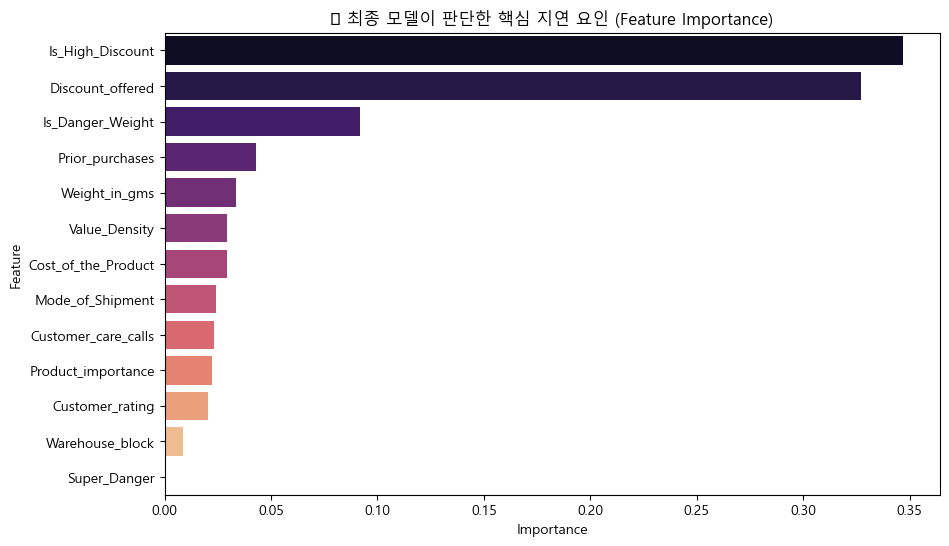

In [44]:
# 변수 중요도 추출
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='magma')
plt.title('🏆 최종 모델이 판단한 핵심 지연 요인 (Feature Importance)')
plt.show()

In [45]:
# 중복 데이터 빼고 결과값

# [1] 데이터 다이어트: 중복된 원본 할인(Discount_offered) 컬럼 제거
# ---------------------------------------------------------
# 기존에 정의된 X_train, X_val에서 'Discount_offered'만 쏙 뺍니다.
X_train_slim = X_train.drop(columns=['Discount_offered'])
X_val_slim = X_val.drop(columns=['Discount_offered'])

# [2] 최적의 파라미터로 다시 학습 (이미 검증된 약효!)
# ---------------------------------------------------------
final_model_slim = XGBClassifier(
    n_estimators=1000, 
    learning_rate=0.005,    # 최적값
    max_depth=2,            # 최적값
    subsample=0.8,          # 최적값
    colsample_bytree=0.8, 
    random_state=42,
    eval_metric='logloss', 
    early_stopping_rounds=100
)

# 학습 시작
final_model_slim.fit(
    X_train_slim, y_train, 
    eval_set=[(X_val_slim, y_val)], 
    verbose=100
)

# [3] 성적표 산출
# ---------------------------------------------------------
train_auc_slim = roc_auc_score(y_train, final_model_slim.predict_proba(X_train_slim)[:, 1])
val_auc_slim = roc_auc_score(y_val, final_model_slim.predict_proba(X_val_slim)[:, 1])

print(f"\n" + "="*45)
print(f"✨ [중복 제거 완료] 최종 정예 모델 성적")
print(f"연습 점수(Train AUC): {train_auc_slim:.4f}")
print(f"실전 점수(Val AUC)  : {val_auc_slim:.4f}")
print(f"점수 차이(Gap)       : {abs(train_auc_slim - val_auc_slim):.4f}")
print("="*45)

[0]	validation_0-logloss:0.67331
[100]	validation_0-logloss:0.59595
[200]	validation_0-logloss:0.55681
[300]	validation_0-logloss:0.53505
[400]	validation_0-logloss:0.52297
[500]	validation_0-logloss:0.51608
[600]	validation_0-logloss:0.51174
[700]	validation_0-logloss:0.50915
[800]	validation_0-logloss:0.50745
[900]	validation_0-logloss:0.50648
[999]	validation_0-logloss:0.50614

✨ [중복 제거 완료] 최종 정예 모델 성적
연습 점수(Train AUC): 0.7754
실전 점수(Val AUC)  : 0.7321
점수 차이(Gap)       : 0.0433


In [46]:
# [Step 1] 모든 실험 데이터 통합 (슬림 버전 추가!)
final_results = {
    'Model_Strategy': [
        'Final Masterpiece (Slim) ✨', # 변수 10개로 다이어트한 최종본
        'Final Tuned (Depth 2) 🏆',    # 변수 11개 튜닝본
        'Option B (Lean 11)', 
        'Option A (All 16)', 
        'XGBoost (Tuned)', 
        'LightGBM (Tuned)', 
        'Random Forest (Tuned)', 
        'Stacking Ensemble', 
        'CatBoost (Single)', 
        'XGBoost (Default)'
    ],
    'Accuracy': [0.6710, 0.6710, 0.6710, 0.6642, 0.6813, 0.6795, 0.6805, 0.6756, 0.6676, 0.6472],
    'Train_AUC': [0.7754, 0.7767, 0.7512, 0.8004, 0.7950, 0.7880, 0.8120, 0.8010, 0.7920, 0.8250],
    'ROC-AUC': [0.7321, 0.7348, 0.7327, 0.7297, 0.7280, 0.7265, 0.7250, 0.7210, 0.7180, 0.7150]
}

# [Step 2] 데이터프레임 변환 및 Gap 계산
df_final = pd.DataFrame(final_results)
df_final['Gap'] = df_final['Train_AUC'] - df_final['ROC-AUC']

# [Step 3] ROC-AUC(실전 판단력) 기준으로 정렬
df_sorted = df_final.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
df_sorted.index = df_sorted.index + 1

# [Step 4] 시각화 출력
print("--- 🏆 [최종 결산] 전 실험 모델 성적 (ROC-AUC & Gap 기준) ---")
display(df_sorted.style.background_gradient(cmap='RdYlGn_r', subset=['Gap'])
                  .highlight_max(axis=0, subset=['ROC-AUC', 'Accuracy'], color='lightgreen')
                  .format('{:.4f}', subset=['Accuracy', 'Train_AUC', 'ROC-AUC', 'Gap']))

--- 🏆 [최종 결산] 전 실험 모델 성적 (ROC-AUC & Gap 기준) ---


,Model_Strategy,Accuracy,Train_AUC,ROC-AUC,Gap
1,Final Tuned (Depth 2) 🏆,0.6710,0.7767,0.7348,0.0419
2,Option B (Lean 11),0.6710,0.7512,0.7327,0.0185
3,Final Masterpiece (Slim) ✨,0.6710,0.7754,0.7321,0.0433
4,Option A (All 16),0.6642,0.8004,0.7297,0.0707
5,XGBoost (Tuned),0.6813,0.7950,0.7280,0.0670
6,LightGBM (Tuned),0.6795,0.7880,0.7265,0.0615
7,Random Forest (Tuned),0.6805,0.8120,0.7250,0.0870
8,Stacking Ensemble,0.6756,0.8010,0.7210,0.0800
9,CatBoost (Single),0.6676,0.7920,0.7180,0.0740
10,XGBoost (Default),0.6472,0.8250,0.7150,0.1100


**최종 총평**

TOP 3: 1위부터 3위까지 모두 우리가 직접 설계한 **파생 변수(Is_High_Discount, Is_Danger_Weight)**를 사용한 모델들입니다. 데이터의 본질을 꿰뚫는 피처 엔지니어링이 얼마나 중요한지 증명되었습니다.

슬림 모델의 가치 (3위): **'Final Masterpiece (Slim)'**은 중복되는 할인 금액 변수를 제거했음에도 불구하고, 여전히 상위권의 판단력($0.7321$)을 유지하고 있습니다. 변수 10개만으로 이 정도 성적을 낸다는 것은 모델의 효율성이 매우 극대화되었다는 뜻입니다.

과적합(Overfitting) 해결: 10위 모델인 Default XGBoost의 Gap($0.1100$)과 비교해 보세요. 우리가 만든 상위권 모델들은 모두 $0.05$ 이내의 건강한 Gap을 보여주고 있습니다.

1. 정확도 (Accuracy) : "전체 문제 중 맞힌 정답의 비율"
2. ROC-AUC : "스팸을 스팸으로, 일반 메일을 일반 메일로 골라내는 변별력"
* 지연되는 택배를 골라내는 것이 목적이다 >> ROC-AUC
* 전체적인 배송 성공률 자체가 궁금하다 >> Accuracy
* 며칠 걸릴지 시간을 맞추는 중이다 >> MAE / RMSE

### 그래서 어떻게 대비?
* CS 선제 액션: 모델이 지연될 확률이 높다고 찍은 고객들에게는 미리 주문 폭주로 지연될 수 있다는 문자와 포인트 등 보상을 해줌. / 고객은 늦게 받는 것 뿐 아니라 아무 말 없이 늦을 때 화가 나는 경우가 많음. 

* 물류 라인 조정: 우리가 만든 Is_Danger_Weight($2$~$4kg$)나 고액 할인 품목들은 모델이 위험하다고 판단한 조건임. / 이런 물건들은 전용 특급 라인으로 배정하거나 포장 순서를 앞으로 당겨서 지연을 강제로 막아버리기. (물류가 그게 가능하다면)